<a href="https://colab.research.google.com/github/mrdbourke/learn-transformers/blob/main/attention_mechanism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [WIP] Attention mechanism

**Focus:** Build intuition to build up to replicating the original Transformer paper.

### This notebook

* Recreate self-attention as per Transformer paper
* Recreate multi-head attention as per Transformer paper

### Later
* Recreate Transformer model architecture
* Train on a simple example

Sources:

* Transformer paper: https://arxiv.org/abs/1706.03762
* The annotated transformer: http://nlp.seas.harvard.edu/2018/04/01/attention.html
* https://lilianweng.github.io/posts/2018-06-24-attention/#self-attention
* https://jaykmody.com/blog/attention-intuition/
* Compact transformers - https://medium.com/pytorch/training-compact-transformers-from-scratch-in-30-minutes-with-pytorch-ff5c21668ed5
* Implemented MHA - https://nn.labml.ai/transformers/mha.html

## What we're going to do

Simple goals:

Replicate the following functions/modules as fast as possible:
* PyTorch's `scaled_dot_product_attention` - https://pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html
  * Explain the intuition of the attention mechanism
* PyTorch's MultiHeadAttention - https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html
  * Both of these are the same equations used in the Transformer paper
* Do with and without masking
* Use these to build on the next chatper: replicating the Transformer architecture
  * Focus on what the inputs and outputs should be (e.g. text/vision/audio, in essence, seq2seq)




In [1]:
import torch
from torch import nn

import torch.nn.functional as F

## Simple scaled-dot-product-attention (no mask)

Attention formula = `softmax((Q, K.T)/torch.sqrt(d_k))V`

$$
\operatorname{Attention}(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{\mathrm{T}}}{\sqrt{d_k}}\right) V
$$

TK:
- Can I replicate this in Google Sheets?... yes I can... kind of (except for softmax, etc)
- Turn this function into the same format as the transformer paper (e.g. figure 2)

In [12]:
def attention(query, key, value):

  # Create the scale factor (sqrt(d_k))
  d_k = torch.sqrt(torch.tensor(query.shape[-1])) # torch.sqrt needs a tensor

  q_k = torch.matmul(query, key.mT) # .mT = matrix Transpose (transposes the last two dimensions)
  q_k_softmax_scale = F.softmax(q_k/torch.sqrt(d_k), dim=-1)
  q_k_softmax_scale_v = torch.matmul(q_k, value)
  return q_k_softmax_scale_v

In [18]:
torch.manual_seed(42)
x = torch.randn(3, 3)

output_custom = attention(query=x, key=x, value=x)
output_custom

tensor([[ 1.1175, -0.5276,  0.2233],
        [ 1.0066, -0.7048,  0.1397],
        [ 1.9621, -0.6285,  0.4030]])

In [19]:
# Does this equal PyTorch's scaled_dot_product_attention?
output_pytorch = F.scaled_dot_product_attention(query=x,
                                                key=x,
                                                value=x)
output_pytorch

tensor([[ 1.1175, -0.5276,  0.2233],
        [ 1.0066, -0.7048,  0.1397],
        [ 1.9621, -0.6285,  0.4030]])

In [20]:
# Should output true
torch.all(output_pytorch.isclose(output_custom))

tensor(True)

## TODO: What is a query, key and value?

* What if I told you you already know about the attention mechanism?... and your local cafe owner knows it very well

* Give an example of different values input and output into our attention mechansim

TK - Can I do sales of different products? Does this relate?

E.g.
* query = sales on monday
* key = product
* value = amount?

Does this work??

In [49]:
# TODO: finalize this and upload it to GitHub (if it works)
!wget https://www.dropbox.com/s/8heqlnrpkf7tlbq/cafe_sales_data_csv.xlsx

--2023-06-16 05:16:02--  https://www.dropbox.com/s/8heqlnrpkf7tlbq/cafe_sales_data_csv.xlsx
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/8heqlnrpkf7tlbq/cafe_sales_data_csv.xlsx [following]
--2023-06-16 05:16:02--  https://www.dropbox.com/s/raw/8heqlnrpkf7tlbq/cafe_sales_data_csv.xlsx
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7d6275bf4c172b6cd3fff26ffb.dl.dropboxusercontent.com/cd/0/inline/B-F50crI8YmW6RKI4NpITcOYY8DWTfu85QVRbiM-T3205oH2qCZ40Q3jvu0-g1SnGF0SLTc72zd-TctpCqNWIIFEu3OgsnyoZB4eCS2MfmEohZHHanK6W2bI6C2viUkLRPh_esrUfPxJZIj11HD4oBwdHRJTF735TuSBv6F3NPzVCg/file# [following]
--2023-06-16 05:16:03--  https://uc7d6275bf4c172b6cd3fff26ffb.dl.dropboxusercontent.com/cd/0/inline/B-F50crI8YmW6RKI4NpITcOYY8DWTfu85QVRbiM-T320

In [50]:
import pandas as pd
df = pd.read_excel("cafe_sales_data_csv.xlsx") # TODO: read_excel with _csv in the filename is confusing...
df

,Unnamed: 0,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,Coffee,0,50,55,68,91,107,84
1,Bread,0,20,22,25,12,40,49
2,Bacon,0,10,15,20,10,65,39
3,Milk,0,15,15,18,16,51,45
4,Bagel,0,21,8,20,60,56,44
5,Sandwich,0,9,8,50,18,62,50
6,Crossiant,0,11,4,3,7,49,55


In [51]:
# Create price vector
price_dict = {
    "coffee": 5,
    "bread": 8,
    "bacon": 15,
    "milk": 4,
    "bagel": 9,
    "sandwich": 12,
    "croissant": 8
}
price_vector = torch.tensor(list(price_dict.values()), dtype=torch.float32)
price_vector

tensor([ 5.,  8., 15.,  4.,  9., 12.,  8.])

In [57]:
# Create sales matrix
sales_matrix = torch.tensor(df.drop("Unnamed: 0", axis=1).values, dtype=torch.float32)
sales_matrix

tensor([[  0.,  50.,  55.,  68.,  91., 107.,  84.],
        [  0.,  20.,  22.,  25.,  12.,  40.,  49.],
        [  0.,  10.,  15.,  20.,  10.,  65.,  39.],
        [  0.,  15.,  15.,  18.,  16.,  51.,  45.],
        [  0.,  21.,   8.,  20.,  60.,  56.,  44.],
        [  0.,   9.,   8.,  50.,  18.,  62.,  50.],
        [  0.,  11.,   4.,   3.,   7.,  49.,  55.]])

In [54]:
print(f"Sales: {sales_matrix.shape} (seven products, seven days of week)")
print(f"Prices: {price_vector.shape} (seven products)")

Sales: torch.Size([7, 7]) (seven products, seven days of week)
Prices: torch.Size([7]) (seven products)


In [90]:
# Find the sales per day
price_vector.matmul(sales_matrix)

tensor([   0., 1005.,  936., 1716., 1577., 3674., 3013.])

In [147]:
price_vector.unsqueeze(1)

tensor([[ 5.],
        [ 8.],
        [15.],
        [ 4.],
        [ 9.],
        [12.],
        [ 8.]])

In [148]:
price_vector

tensor([ 5.,  8., 15.,  4.,  9., 12.,  8.])

In [149]:
# WRONG: Sales per item per day
price_vector * sales_matrix

tensor([[   0.,  400.,  825.,  272.,  819., 1284.,  672.],
        [   0.,  160.,  330.,  100.,  108.,  480.,  392.],
        [   0.,   80.,  225.,   80.,   90.,  780.,  312.],
        [   0.,  120.,  225.,   72.,  144.,  612.,  360.],
        [   0.,  168.,  120.,   80.,  540.,  672.,  352.],
        [   0.,   72.,  120.,  200.,  162.,  744.,  400.],
        [   0.,   88.,   60.,   12.,   63.,  588.,  440.]])

In [146]:
# CORRECT: Manipulate price vector before multiplying to sales matrix
price_vector.unsqueeze(1) * sales_matrix

tensor([[  0., 250., 275., 340., 455., 535., 420.],
        [  0., 160., 176., 200.,  96., 320., 392.],
        [  0., 150., 225., 300., 150., 975., 585.],
        [  0.,  60.,  60.,  72.,  64., 204., 180.],
        [  0., 189.,  72., 180., 540., 504., 396.],
        [  0., 108.,  96., 600., 216., 744., 600.],
        [  0.,  88.,  32.,  24.,  56., 392., 440.]])

In [157]:
# TK note:
# matmul = sum over dim=0 -> item sales per day
# manual setup = sum over dim=1 -> item sales per week
total_item_sales_per_week = torch.sum(price_vector.unsqueeze(1) * sales_matrix, dim=1)
total_item_sales_per_week

tensor([2275., 1344., 2385.,  640., 1881., 2364., 1032.])

In [162]:
total_sales_per_day = torch.sum(price_vector.unsqueeze(1) * sales_matrix, dim=0)
total_sales_per_day

tensor([   0., 1005.,  936., 1716., 1577., 3674., 3013.])

In [167]:
# TODO: try einsum? or einops?

TK - try create an example for attention

In [ ]:
# Create a query ("What are the sales on Wednesday?")
sales_on_wednesday_vector = torch.zeros(7) # days of week
sales_on_wednesday_vector[2] = 1
sales_on_wednesday_vector

tensor([0., 0., 1., 0., 0., 0., 0.])

In [ ]:
# Compare the sales matrix (key) to the query (Q * K.T)
wednesday_sales = sales_on_wednesday_vector.matmul(sales_matrix.T)
wednesday_sales

tensor([55., 22., 15., 15.,  8.,  8.,  4.])

Why scale?

Watch this... softmax blows it out of the water...

In [ ]:
F.softmax(wednesday_sales, dim=0)

tensor([1.0000e+00, 4.6589e-15, 4.2484e-18, 4.2484e-18, 3.8740e-21, 3.8740e-21,
        7.0955e-23])

Now scale...

In [ ]:
wednesday_sales.shape

torch.Size([7])

In [ ]:
F.softmax(wednesday_sales / torch.sqrt(torch.tensor(wednesday_sales.shape[0])), dim=0)

tensor([1.0000e+00, 3.8293e-06, 2.7170e-07, 2.7170e-07, 1.9277e-08, 1.9277e-08,
        4.2507e-09])

Still blown out of the water but better... (could normalize these values first)

e.g.

```python
norm_tensor = (x - torch.min(x))/(torch.max(x) - torch.min(x))
```

In [ ]:
F.softmax(wednesday_sales / torch.sqrt(torch.tensor(wednesday_sales.shape[0])), dim=0) @ price_vector

tensor(5.0000)

In [ ]:
# Total sales on Wednesday
attention_to_pay_on_wednesdays = wednesday_sales @ price_vector # price_vector = value
attention_to_pay_on_wednesdays

tensor(936.)

### TODO: Try normalizing values

See:

In [ ]:
# NEXT:
# Try normalizing the tensor values and see how they change/improve stability
# Softmax on values with large differences = blows larger values out of the water (e.g. 1.0 vs 1e-10... basically nothing)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
min_max = MinMaxScaler()
sales_matrix_normalized = min_max.fit(sales_matrix).transform(sales_matrix)
sales_matrix_normalized

array([[0.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        ],
       [0.        , 0.26829268, 0.35294118, 0.33846154, 0.05952381,
        0.        , 0.22222222],
       [0.        , 0.02439024, 0.21568627, 0.26153846, 0.03571429,
        0.37313433, 0.        ],
       [0.        , 0.14634146, 0.21568627, 0.23076923, 0.10714286,
        0.1641791 , 0.13333333],
       [0.        , 0.29268293, 0.07843137, 0.26153846, 0.63095238,
        0.23880597, 0.11111111],
       [0.        , 0.        , 0.07843137, 0.72307692, 0.13095238,
        0.32835821, 0.24444444],
       [0.        , 0.04878049, 0.        , 0.        , 0.        ,
        0.13432836, 0.35555556]])

In [ ]:
def min_max_normalize_tensor(x):
  """
  See: https://en.wikipedia.org/wiki/Feature_scaling#Rescaling_(min-max_normalization)
  """

  return (x - torch.min(x)) / (torch.max(x) - torch.min(x))

In [ ]:
price_vector

tensor([ 5.,  8., 15.,  4.,  9., 12.,  8.])

In [ ]:
sales_matrix_normalized = min_max_normalize_tensor(sales_matrix)
price_vector_normalized = min_max_normalize_tensor(price_vector)
sales_matrix_normalized, price_vector_normalized

(tensor([[0.0000, 0.4673, 0.5140, 0.6355, 0.8505, 1.0000, 0.7850],
         [0.0000, 0.1869, 0.2056, 0.2336, 0.1121, 0.3738, 0.4579],
         [0.0000, 0.0935, 0.1402, 0.1869, 0.0935, 0.6075, 0.3645],
         [0.0000, 0.1402, 0.1402, 0.1682, 0.1495, 0.4766, 0.4206],
         [0.0000, 0.1963, 0.0748, 0.1869, 0.5607, 0.5234, 0.4112],
         [0.0000, 0.0841, 0.0748, 0.4673, 0.1682, 0.5794, 0.4673],
         [0.0000, 0.1028, 0.0374, 0.0280, 0.0654, 0.4579, 0.5140]]),
 tensor([0.0909, 0.3636, 1.0000, 0.0000, 0.4545, 0.7273, 0.3636]))

### TODO: Try standardizing

See: https://en.wikipedia.org/wiki/Feature_scaling#Standardization_(Z-score_Normalization)

In [ ]:
torch.std(x, dim=0)

tensor([0.9268, 1.0037, 0.8458, 1.2510, 0.9081, 1.0602, 1.2140, 0.7745, 0.7807,
        0.7785])

In [ ]:
def standardize_tensor(x):
  """
  See: https://en.wikipedia.org/wiki/Feature_scaling#Standardization_(Z-score_Normalization)
  """
  return (x - torch.mean(x)) / torch.std(x)

In [ ]:
sales_matrix_standardized = standardize_tensor(sales_matrix)
price_vector_standardized = standardize_tensor(price_vector)
price_vector_standardized

tensor([-0.9730, -0.1871,  1.6467, -1.2350,  0.0748,  0.8608, -0.1871])

In [ ]:
price_vector

tensor([ 5.,  8., 15.,  4.,  9., 12.,  8.])

In [ ]:
# Create a query ("What are the sales on Wednesday?")
sales_on_wednesday_vector = torch.zeros(7) # days of week
sales_on_wednesday_vector[2] = 1
sales_on_wednesday_vector

tensor([0., 0., 1., 0., 0., 0., 0.])

In [ ]:
sales_matrix_standardized

tensor([[-1.1194,  0.7374,  0.9231,  1.4059,  2.2600,  2.8542,  2.0000],
        [-1.1194, -0.3767, -0.3024, -0.1910, -0.6738,  0.3661,  0.7003],
        [-1.1194, -0.7480, -0.5623, -0.3767, -0.7480,  1.2945,  0.3289],
        [-1.1194, -0.5623, -0.5623, -0.4509, -0.5252,  0.7745,  0.5517],
        [-1.1194, -0.3395, -0.8223, -0.3767,  1.1088,  0.9602,  0.5146],
        [-1.1194, -0.7852, -0.8223,  0.7374, -0.4509,  1.1830,  0.7374],
        [-1.1194, -0.7109, -0.9708, -1.0080, -0.8594,  0.7003,  0.9231]])

In [ ]:
F.softmax(sales_on_wednesday_vector.unsqueeze(0).matmul(sales_matrix_standardized.T)/7, dim=1) @ price_vector_standardized

tensor([-0.0365])

In [ ]:
F.softmax(sales_on_wednesday_vector.unsqueeze(0).matmul(sales_matrix.T)/7, dim=1) @ price_vector

tensor([5.0707])

In [ ]:
sales_on_monday = torch.zeros(7)
sales_on_monday[0] = 1
print(sales_on_monday)
F.softmax(sales_on_monday.unsqueeze(0).matmul(sales_matrix.T)/7, dim=1) @ price_vector

tensor([0., 0., 0., 0., 0., 0., 1.])


tensor([5.1422])

In [ ]:
# Non-standardize

In [ ]:
sales_on_monday = torch.zeros(7)
sales_on_monday[5] = 1
print(sales_on_monday)
F.softmax(sales_on_monday.unsqueeze(0).matmul(sales_matrix_standardized.T)/7, dim=1) @ price_vector_standardized

tensor([0., 0., 0., 0., 0., 1., 0.])


tensor([-0.0193])

In [ ]:
day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_values = range(0, 7)
day_dict = dict(zip(day_values, day_names))
day_dict

{0: 'Monday',
 1: 'Tuesday',
 2: 'Wednesday',
 3: 'Thursday',
 4: 'Friday',
 5: 'Saturday',
 6: 'Sunday'}

In [ ]:
# Non-standardize
for i in range(7):
  day_tensor = torch.zeros(7)
  day_tensor[i] = 1
  day_name = day_dict[i]

  print(f"\nDay name: {day_name}")
  print(f"Day tensor: {day_tensor}")
  # day_tensor_standardize = standardize_tensor(day_tensor)
  d_k = day_tensor.shape[-1]
  print(d_k)
  attn_score = F.softmax(day_tensor.unsqueeze(1).matmul(sales_matrix.T)/torch.sqrt(torch.tensor(7)), dim=1) @ price_vector
  print(f"Attention score: {attn_score}")


Day name: Monday
Day tensor: tensor([1., 0., 0., 0., 0., 0., 0.])
7


RuntimeError: ignored

In [ ]:
# Standardize
# TODO: does this work for the triangle matrix?
# e.g. triangle down the left to bottom right corner
for i in range(7):
  day_tensor = torch.zeros(7)
  day_tensor[i] = 1
  day_name = day_dict[i]

  print(f"\nDay name: {day_name}")
  print(f"Day tensor: {day_tensor}")
  day_tensor_standardize = standardize_tensor(day_tensor)
  attn_score = F.softmax(day_tensor_standardize.unsqueeze(0).matmul(sales_matrix_standardized.T)/torch.sqrt(torch.tensor(7)), dim=1) @ price_vector_standardized
  print(f"Attention score: {attn_score}")


Day name: Monday
Day tensor: tensor([1., 0., 0., 0., 0., 0., 0.])
Attention score: tensor([0.0979])

Day name: Tuesday
Day tensor: tensor([0., 1., 0., 0., 0., 0., 0.])
Attention score: tensor([-0.0585])

Day name: Wednesday
Day tensor: tensor([0., 0., 1., 0., 0., 0., 0.])
Attention score: tensor([-0.0432])

Day name: Thursday
Day tensor: tensor([0., 0., 0., 1., 0., 0., 0.])
Attention score: tensor([0.1432])

Day name: Friday
Day tensor: tensor([0., 0., 0., 0., 1., 0., 0.])
Attention score: tensor([-0.2104])

Day name: Saturday
Day tensor: tensor([0., 0., 0., 0., 0., 1., 0.])
Attention score: tensor([0.0885])

Day name: Sunday
Day tensor: tensor([0., 0., 0., 0., 0., 0., 1.])
Attention score: tensor([-0.0547])


In [ ]:
all_days = torch.eye(7)

attention(query=all_days,
          key=sales_matrix,
          value=price_vector)

torch.Size([7, 7])


tensor([8.7143, 5.0001, 5.0000, 5.0078, 5.0000, 5.0000, 5.0001])

In [ ]:
all_days = torch.eye(7)
all_days_standardized = standardize_tensor(all_days)

attention(query=all_days_standardized,
          key=sales_matrix_standardized,
          value=price_vector_standardized.unsqueeze(1))

torch.Size([7, 7])


tensor([[ 0.1000],
        [-0.0623],
        [-0.0458],
        [ 0.1560],
        [-0.2222],
        [ 0.0946],
        [-0.0583]])

In [ ]:
F.scaled_dot_product_attention(query=all_days_standardized,
                               key=sales_matrix_standardized,
                               value=price_vector_standardized.unsqueeze(1))

tensor([[ 0.1000],
        [-0.0623],
        [-0.0458],
        [ 0.1560],
        [-0.2222],
        [ 0.0946],
        [-0.0583]])

In [ ]:
standardize_tensor_day = standardize_tensor(sales_on_monday)
standardize_tensor_day

tensor([-0.3780, -0.3780, -0.3780, -0.3780, -0.3780,  2.2678, -0.3780])

In [ ]:
# Combine with the key (<q, k.T>)
wednesday_sales = sales_on_wednesday_vector.matmul(sales_matrix_standardized.T)
wednesday_sales

tensor([ 0.9231, -0.3024, -0.5623, -0.5623, -0.8223, -0.8223, -0.9708])

In [ ]:
sales_matrix

tensor([[  0.,  50.,  55.,  68.,  91., 107.,  84.],
        [  0.,  20.,  22.,  25.,  12.,  40.,  49.],
        [  0.,  10.,  15.,  20.,  10.,  65.,  39.],
        [  0.,  15.,  15.,  18.,  16.,  51.,  45.],
        [  0.,  21.,   8.,  20.,  60.,  56.,  44.],
        [  0.,   9.,   8.,  50.,  18.,  62.,  50.],
        [  0.,  11.,   4.,   3.,   7.,  49.,  55.]])

In [ ]:
# Softmax on the sales (not so blown out! ... once the values were standardized)
wednesday_sales = F.softmax(wednesday_sales, dim=0)
wednesday_sales

tensor([0.1917, 0.1399, 0.1358, 0.1358, 0.1327, 0.1327, 0.1313])

In [ ]:
# Scale on the sales
wednesday_sales = wednesday_sales/torch.sqrt(torch.tensor(wednesday_sales.shape[0]))
wednesday_sales

tensor([0.0724, 0.0529, 0.0513, 0.0513, 0.0502, 0.0502, 0.0496])

In [ ]:
# Multiply by the value to get the attention
attention_to_pay_on_wednesdays = wednesday_sales @ price_vector_standardized
attention_to_pay_on_wednesdays

tensor(-0.0216)

In [ ]:
price_vector_standardized

tensor([-0.9730, -0.1871,  1.6467, -1.2350,  0.0748,  0.8608, -0.1871])

In [ ]:
each_day = torch.eye(7)
each_day_standardized = standardize_tensor(each_day)
each_day, each_day_standardized

(tensor([[1., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 1.]]),
 tensor([[ 2.4244, -0.4041, -0.4041, -0.4041, -0.4041, -0.4041, -0.4041],
         [-0.4041,  2.4244, -0.4041, -0.4041, -0.4041, -0.4041, -0.4041],
         [-0.4041, -0.4041,  2.4244, -0.4041, -0.4041, -0.4041, -0.4041],
         [-0.4041, -0.4041, -0.4041,  2.4244, -0.4041, -0.4041, -0.4041],
         [-0.4041, -0.4041, -0.4041, -0.4041,  2.4244, -0.4041, -0.4041],
         [-0.4041, -0.4041, -0.4041, -0.4041, -0.4041,  2.4244, -0.4041],
         [-0.4041, -0.4041, -0.4041, -0.4041, -0.4041, -0.4041,  2.4244]]))

In [ ]:
# Attention to pay each day
each_day = torch.ones((7))

def attention(query, key, value):
  d_k = torch.tensor(query.shape[-1]) # torch.sqrt needs a tensor
  print(d_k)
  q_k = F.softmax(torch.matmul(query, key.T)/torch.sqrt(d_k), dim=-1)
  print(q_k.shape)
  return torch.matmul(q_k, value)

attention(query=each_day_standardized,
          key=sales_matrix_standardized,
          value=price_vector_standardized)

tensor(7)
torch.Size([7, 7])


tensor([ 0.1000, -0.0623, -0.0458,  0.1560, -0.2222,  0.0946, -0.0583])

In [ ]:
# Attention to pay each day
monday = torch.zeros(7)
monday[0] = 1
monday_standardized = standardize_tensor(monday)
print(monday)
print(monday_standardized)

def attention(query, key, value):
  d_k = torch.tensor(query.shape[-1]) # torch.sqrt needs a tensor
  print(d_k)
  q_k = F.softmax(torch.matmul(query, key.T)/torch.sqrt(d_k), dim=-1)
  print(q_k.shape)
  return torch.matmul(q_k, value)

attention(query=monday_standardized,
          key=sales_matrix_standardized,
          value=price_vector_standardized)

tensor([1., 0., 0., 0., 0., 0., 0.])
tensor([ 2.2678, -0.3780, -0.3780, -0.3780, -0.3780, -0.3780, -0.3780])
tensor(7)
torch.Size([7])


tensor(0.0979)

In [ ]:
# UPTOHERE
# NEXT: clean up all of the above so it makes sense... in a bit of a mess now
# Less but better...

In [ ]:
# query = day of week
# key = sales per day
# value = prices of products
# result/output = value of total products sold on target day (how much attention to pay to a certain day)

# TK - if you wanted to get more information, you could increase the cafe sales to (52, 7) -> sales per day for 52 weeks in a year
# -> or (5, 52, 7) (year, weeks, days) -> sales per day per week for 5 years

# TODO:

# How does this relate to attention?

# At a large enough scale, you can do this for words in sentences.
# For example, say we have 100 sentences.
# Which words mean the most to which other words?
# In a small sample like this, you might be able to design fixed values (like our coffee shop for different products).
# But with a larger scale, you might have to design different values for different contexts.
# The analogy being in a coffee shop in Australia, your pricing and products might be different to a coffee shop in Africa.
# With a large enough corpus of words, having fixed values isn't going to work.
# But the principle remains, how important is each other word to another word in a sentence?
# What should you do?
# Well, you'd never have time to assign a value for each word across a huge corpus.
# So you can make the values for each word learnable.
# Much like you might adjust your cafe prices and sales events given different days of the week.
# The sales on Monday are very low (zero) because your cafe is closed on Monday.
# Your customers don't assign much money (or attention) to your cafe on Monday's since they know it's closed.
# Much like the attention score for the word "cat" might be very low in comparison to the word "sodium metabisulfite" because the two hardly ever occur in context of each other.

# Why self-attention?

# Applying the mechanism to itself over and over for different sequences enables the system to learn from the data itself.
# As in, what words keep on showing up in the context of other words?
# The dot product/matrix multiplication will amplify larger values.
# In essence, given the query "dog" and the key of every word in the vocabulary, hopefully the model will learn to return "cat" as a likely value and "sodium metabisulfite" as a less likely value.

## TODO: Simple scaled-dot-product-attention (with mask)

Next:
- Read through GPT-from-scratch again
- Read through Facebook's xformers
- Read through Transformers from scratch blog post

--

* see: https://jaykmody.com/blog/gpt-from-scratch/#causal
* And see: https://github.com/facebookresearch/xformers/blob/main/xformers/components/attention/attention_mask.py
  * Default to causal mask: https://github.com/facebookresearch/xformers/blob/97daac83cece6d3d77bb09479777ad6e8ef7dfed/xformers/components/attention/attention_mask.py#LL74C16-L74C16 (`make_causal()`)

In [ ]:
# Make causal mask, see: https://jaykmody.com/blog/gpt-from-scratch/#causal
additive_mask = torch.triu(
    # torch.ones(x.shape[0], x.shape[0]) * float("inf"),
    torch.ones(x.shape[0], x.shape[0]) * -1e10, # can use -1e10 to prevent nans
    diagonal=1
)

additive_mask

tensor([[ 0.0000e+00, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10,
         -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10],
        [ 0.0000e+00,  0.0000e+00, -1.0000e+10, -1.0000e+10, -1.0000e+10,
         -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.0000e+10, -1.0000e+10,
         -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -1.0000e+10,
         -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+0

In [ ]:
def attention_with_mask(query, key, value, mask=None):
  d_k = torch.tensor(query.shape[-1]) # torch.sqrt needs a tensor
  q_k = torch.matmul(query, key.T) / torch.sqrt(d_k)
  print(q_k.shape)


  print(f"q_k: {q_k}")

  # Apply attention mask
  if mask is not None:
    q_k = q_k + mask

  print(f"q_k with mask: {q_k}")

  # Softmax
  attn = F.softmax(q_k, dim=-1)

  return torch.matmul(attn, value), attn

attention_with_mask(query=x, key=x, value=x, mask=additive_mask)

torch.Size([10, 10])
q_k: tensor([[ 6.0130e+00, -7.9063e-01, -1.6862e+00, -5.4706e-01, -1.2946e+00,
         -1.5651e-01, -9.5597e-01, -1.4247e-01,  4.3972e-01, -5.1831e-01],
        [-7.9063e-01,  2.3093e+00, -5.7266e-01,  6.2206e-01,  3.1750e-01,
         -9.4774e-01,  1.2001e-01,  1.7332e-01,  1.3094e+00, -7.1141e-01],
        [-1.6862e+00, -5.7266e-01,  3.3930e+00,  3.3083e-03,  1.3948e-01,
         -2.0294e-01,  2.6444e+00,  1.1129e+00, -1.9716e-01,  2.9590e-01],
        [-5.4706e-01,  6.2206e-01,  3.3083e-03,  2.3570e+00,  2.2022e+00,
         -6.3796e-01,  1.2451e+00,  7.0473e-01,  8.8856e-01, -9.7713e-01],
        [-1.2946e+00,  3.1750e-01,  1.3948e-01,  2.2022e+00,  4.3364e+00,
          2.9038e-01, -3.1773e-01,  1.8019e+00,  2.3513e-01, -5.8754e-01],
        [-1.5651e-01, -9.4774e-01, -2.0294e-01, -6.3796e-01,  2.9038e-01,
          1.7630e+00, -5.9041e-01, -8.1988e-02, -7.1263e-01,  1.0189e+00],
        [-9.5597e-01,  1.2001e-01,  2.6444e+00,  1.2451e+00, -3.1773e-01,
      

(tensor([[ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784, -1.2345, -0.0431, -1.6047,
          -0.7521,  1.6487],
         [-0.2925, -1.2790, -0.6577, -0.6261, -0.7064,  0.6764,  1.5697, -0.2219,
          -0.5084,  0.4917],
         [-0.7351,  1.0349,  0.7731,  1.6162,  1.2376,  1.2712,  0.6256,  1.2893,
          -0.2397,  0.0589],
         [-0.2166,  0.6004, -1.0463, -0.6979, -0.1510,  1.4382,  0.5008, -0.3120,
           0.1167, -0.4545],
         [-1.3844,  0.9470, -0.9017, -0.6031, -1.1193,  2.0389, -1.0030, -0.4560,
          -0.7730, -0.6367],
         [-0.0906,  0.6622, -0.3702,  0.5163, -0.5373, -0.0254, -0.8781, -0.1037,
          -0.2517,  0.4371],
         [-0.1764,  1.6977, -0.9631,  1.3173,  1.3377,  0.9195,  1.9504,  0.5652,
           0.2647, -0.1750],
         [-0.8553,  1.1510, -0.3746,  0.3669,  0.0303,  0.8280,  0.4054, -0.3187,
          -1.3058, -0.4890],
         [-0.1844,  0.3723, -0.7960, -0.2162,  0.2121,  0.7338,  0.8952, -0.2755,
          -0.4961,  0.1444],
 

## TODO: Why scaled?

TL;DR softmax can get out of hand with large values

In [ ]:
small_values = torch.tensor([1, 2, 3], dtype=torch.float32) # need dtype otherwise error
big_values = small_values * 10
huge_values = big_values * 10

small_softmax = F.softmax(small_values, dim=0)
big_softmax = F.softmax(big_values, dim=0)
huge_softmax = F.softmax(huge_values, dim=0)

print(f"Small values: {small_values}\nSmall softmax: {small_softmax}\n")
print(f"Big values: {big_values}\nBig softmax: {big_softmax}\n")
print(f"Huge values: {huge_values}\nHuge softmax: {huge_softmax}\n")

Small values: tensor([1., 2., 3.])
Small softmax: tensor([0.0900, 0.2447, 0.6652])

Big values: tensor([10., 20., 30.])
Big softmax: tensor([2.0611e-09, 4.5398e-05, 9.9995e-01])

Huge values: tensor([100., 200., 300.])
Huge softmax: tensor([0.0000e+00, 3.7835e-44, 1.0000e+00])



## TODO: Why dot-product?

TL;DR dot product measures how closely two vectors are related

* big values = close
* negative values = far away
* zero value = same direction? (TK - fix this)

See:
* 3blue1brown on dot product - https://www.youtube.com/watch?v=LyGKycYT2v0

tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])


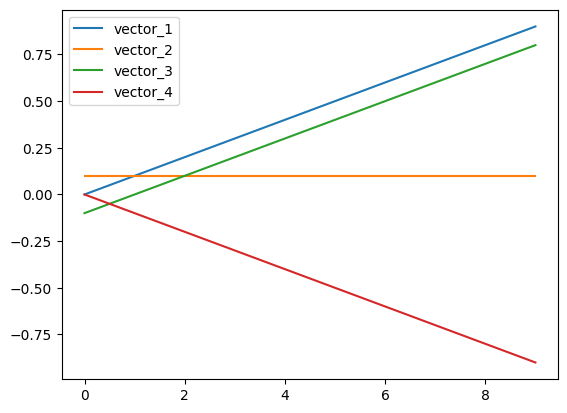

In [88]:
vector_1 = torch.arange(0, 1, 0.1)
vector_2 = torch.ones_like(vector_1) / 10
vector_3 = vector_1 - 0.1
vector_4 = -vector_1
print(vector_2)

import matplotlib.pyplot as plt

plt.plot(vector_1, label="vector_1")
plt.plot(vector_2, label="vector_2")
plt.plot(vector_3, label="vector_3")
plt.plot(vector_4, label="vector_4")
plt.legend();

In [84]:
cosine_sim = nn.CosineSimilarity(dim=0)
cosine_sim(vector_1, vector_1)

tensor(1.0000)

In [40]:
torch.dot(vector_1, vector_1)

tensor(2.8500)

In [33]:
torch.dot(vector_1, vector_2)

tensor(0.4500)

In [35]:
torch.dot(vector_1, vector_3)

tensor(2.4000)

In [36]:
torch.dot(vector_2, vector_3)

tensor(0.3500)

In [38]:
torch.dot(vector_1, vector_4)

tensor(-2.8500)

In [67]:
# Sales example (total sales on Wednesday)
torch.dot(price_vector, sales_matrix[:, 2])

tensor(936.)

In [75]:
# Same as taking the multiple and then summing them
torch.sum(price_vector * df["Wednesday"].values, dtype=torch.float32)

tensor(936.)

In [80]:
# Compresses the information into a single number
cosine_sim(price_vector, price_vector)

tensor(1.0000)

In [82]:
import numpy as np
np.dot(price_vector, price_vector)

619.0

## TODO: Replicate PyTorch's `scaled_dot_product_attention`

(minus all the fancy optimizations, the library can do those for us)

See: https://pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html

Also see: https://github.com/facebookresearch/xformers/blob/main/xformers/components/attention/core.py#L297

In [ ]:
# Optionally use the context manager to ensure one of the fused kerenels is run
torch.manual_seed(42)

query = torch.rand(32, 8, 128, 64) # [batch_size, num_heads, sequence_length, embedding_dim]
key = torch.rand(32, 8, 128, 64)
value = torch.rand(32, 8, 128, 64)


In [ ]:
output_pytorch = F.scaled_dot_product_attention(query, key, value)
print(output_pytorch.shape)
print(output_pytorch[0, 0, 0])

torch.Size([32, 8, 128, 64])
tensor([0.5430, 0.5479, 0.5143, 0.4744, 0.5149, 0.4867, 0.5063, 0.5088, 0.4863,
        0.4620, 0.4989, 0.5488, 0.4746, 0.4955, 0.5334, 0.4886, 0.5158, 0.5267,
        0.5183, 0.5251, 0.4939, 0.5092, 0.5408, 0.4267, 0.4645, 0.5221, 0.5587,
        0.4917, 0.5142, 0.4762, 0.4839, 0.4837, 0.4937, 0.4671, 0.4898, 0.5195,
        0.4942, 0.4938, 0.4783, 0.4796, 0.5454, 0.4686, 0.5112, 0.5717, 0.5081,
        0.4588, 0.5151, 0.4970, 0.4649, 0.5143, 0.5019, 0.5053, 0.4928, 0.5278,
        0.5332, 0.5121, 0.4882, 0.4992, 0.5197, 0.4865, 0.5028, 0.4908, 0.4975,
        0.4808])


In [ ]:
def attention(query, key, value):
  d_k = torch.tensor(query.shape[-1]) # torch.sqrt needs a tensor
  print(torch.matmul(query, key.mT).shape)
  print(key.mT.shape)
  print(key.transpose(-2, -1).shape)

  # tensor.mT is equivalent to tensor.transpose(-2, -1), see: https://pytorch.org/docs/stable/tensors.html#torch.Tensor.mT
  # -> last two dimensions reversed
  q_k = F.softmax(torch.matmul(query, key.mT)/torch.sqrt(d_k), dim=-1)

  print(d_k)

  print(d_k.shape, q_k.shape, value.shape)
  print(q_k.shape, value.mT.shape)

  return torch.matmul(q_k, value)

output_custom = attention(query, key, value)
print(output_pytorch.shape)
print(output_pytorch[0, 0, 0])

torch.Size([32, 8, 128, 128])
torch.Size([32, 8, 64, 128])
torch.Size([32, 8, 64, 128])
tensor(64)
torch.Size([]) torch.Size([32, 8, 128, 128]) torch.Size([32, 8, 128, 64])
torch.Size([32, 8, 128, 128]) torch.Size([32, 8, 64, 128])
torch.Size([32, 8, 128, 64])
tensor([0.5430, 0.5479, 0.5143, 0.4744, 0.5149, 0.4867, 0.5063, 0.5088, 0.4863,
        0.4620, 0.4989, 0.5488, 0.4746, 0.4955, 0.5334, 0.4886, 0.5158, 0.5267,
        0.5183, 0.5251, 0.4939, 0.5092, 0.5408, 0.4267, 0.4645, 0.5221, 0.5587,
        0.4917, 0.5142, 0.4762, 0.4839, 0.4837, 0.4937, 0.4671, 0.4898, 0.5195,
        0.4942, 0.4938, 0.4783, 0.4796, 0.5454, 0.4686, 0.5112, 0.5717, 0.5081,
        0.4588, 0.5151, 0.4970, 0.4649, 0.5143, 0.5019, 0.5053, 0.4928, 0.5278,
        0.5332, 0.5121, 0.4882, 0.4992, 0.5197, 0.4865, 0.5028, 0.4908, 0.4975,
        0.4808])


In [ ]:
# Assert all of the output values are close
assert torch.all(output_custom.isclose(output_pytorch))

## TODO: A cool trick with `einops`

In [ ]:
# What about einops?
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.2 MB/s eta 0:00:00


In [ ]:
from einops import rearrange, reduce, repeat

print(f"Key shape: {key.shape} [batch, num_heads, input_sequence, embedding_dim]")

### The following all do the same ###

# Rearrange the shape for our use case
key_rearranged = rearrange(key, 'batch heads input embed -> batch heads embed input')

# Key tranposed
key_transposed = key.transpose(-2, -1)

# Key mT (note: use .mT rather than .T on tensors with more than two dimensions)
key_mt = key.mT

print(key_rearranged.shape, key_transposed.shape, key_mt.shape)
assert key_rearranged.shape == key_transposed.shape == key_mt.shape

Key shape: torch.Size([32, 8, 128, 64]) [batch, num_heads, input_sequence, embedding_dim]
torch.Size([32, 8, 64, 128]) torch.Size([32, 8, 64, 128]) torch.Size([32, 8, 64, 128])


## TODO: Why multi-head attention?

TL;DR more opportunities to learn (e.g. 8x64 scaled dot-product attention = better than 1*512)

TK:
- One big matrix multiplication better than lots of small ones
- Just perform a `nn.Linear()` then break it up